In [1]:
import dit
import numpy as np
import scipy.stats as st
import string
import itertools
import random

import distribution_sampler as sampler
from tqdm.notebook import tqdm
from typing import List
from dit.validate import InvalidNormalization
from dit.exceptions import ditException

import matplotlib.pyplot as plt

import multiprocessing as mp
import os
import time

In [2]:
def get_vars(n_vars: int) -> List[str]:
    vs = ['X{}'.format(i) for i in range(n_vars-1)]
    vs.append('Y')
    return vs

def get_labels(n_vars: int, n_states: int) -> List[str]:
    if n_states < 1 or n_states > 10:
        raise ValueError("states should be greater than 0 and  less than or equal to 10")
    return [''.join(i) for i in itertools.product(string.digits[:n_states], repeat=n_vars)]


def generate_distribution(n_vars: int, n_states: int, entropy_level: float) -> dit.Distribution:
    var_names = get_vars(n_vars)
    state_labels = get_labels(n_vars, n_states)
    pmf = sampler.sample(n_states**n_vars, level=entropy_level)
    pmf = np.log(pmf)
    d = dit.Distribution(state_labels, pmf=pmf, base=np.e)
    d.set_rv_names(var_names)
    return d

def get_marginals(d: dit.Distribution) -> (dit.Distribution, List[dit.Distribution]):
    rvs = d.get_rv_names()[:-1]  #everything except the output
    return d.condition_on(rvs)

def get_joint(X: dit.Distribution, YgX: List[dit.Distribution]) -> dit.Distribution:
    return dit.joint_from_factors(X, YgX).copy(base=np.e)

def print_conditional(YgX):
    for i, Y in enumerate(YgX):
        Y.make_dense()
        print("{}: ".format(i), Y.pmf)


In [3]:
d3 = generate_distribution(3,3, 0.75)
d6 = generate_distribution(6,3, 0.75)
x3, ygx3 = get_marginals(d3)
x6, ygx6 = get_marginals(d6)

In [8]:
%%timeit
x = x6
#individual_nudge(x)
local_nudge(x)
#synergistic_nudge(x)
#global_nudge(x)

427 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def log_add(p, n):
    result = np.zeros(len(p), dtype=p.dtype)
    PgeN = p >= n
    
    result[PgeN] = p[PgeN] + np.log1p(np.exp(n[PgeN] - p[PgeN]))
    result[~PgeN] = n[~PgeN] + np.log1p(np.exp(p[~PgeN] - n[~PgeN]))
    return result

def log_subtract(p, n):
    result = np.zeros(len(p), dtype=p.dtype)
    
    PleN = p <= n
    n_is_inf = n == -np.inf
    other = ~PleN & ~n_is_inf
    
    result[PleN] = -np.inf
    result[n_is_inf] = p[n_is_inf]
    result[other] = p[other] + np.log1p(-np.exp(n[other]-p[other]))
    return result

def log_nudge(prob, nudge, s):
    new_prob = np.zeros(len(prob), dtype=prob.dtype)
    #nudge = np.log(np.abs(nudge))
    pos, neg = s > 0, s < 0
    new_prob[pos] = log_add(prob[pos], nudge[pos])
    new_prob[neg] = log_subtract(prob[neg], nudge[neg])
    return new_prob



In [357]:
d = generate_distribution(3,3, 0.1)
X, YgX = get_marginals(d)
print(X.get_base())
for Y in YgX:
    print(Y.get_base())
new_d = dit.joint_from_factors(X,YgX).copy(np.e)
print(new_d.get_base())

2.718281828459045
2.718281828459045
2.718281828459045
2.718281828459045
2.718281828459045
2.718281828459045
2.718281828459045
2.718281828459045
2.718281828459045
2.718281828459045
2.718281828459045


In [358]:
generate_nudge_binomial(27, 0.1, p=True).sum()

[-1.14783907e-03  6.25908890e-04 -6.52397404e-04  4.06325344e-04
  1.58915922e-02  4.32368427e-04  3.55006686e-03  1.97779023e-03
  2.74478925e-03  4.18450080e-04 -1.53234257e-02 -9.82756427e-03
  7.88188146e-05 -4.75924491e-03  2.91831911e-03  1.16920493e-03
  2.92024333e-03  4.31907791e-03  3.03376974e-03  4.60314330e-03
 -5.88439215e-03 -1.06690522e-02 -7.53920141e-04  7.94478083e-04
 -9.82164131e-04  5.19196360e-04  3.59645717e-03]


4.336808689942018e-18

In [6]:
def generate_nudge(size: int, eps: float, p=False):
    nudge = np.zeros(size)
    if size % 2 == 0:
        nudge = 0.5*eps*np.random.permutation(np.concatenate([np.random.dirichlet([1.]*int(0.5*size)),
                                                 -np.random.dirichlet([1.]*int(0.5*size))]))
    else:
        u, v = int(np.floor(size/2)), int(np.ceil(size/2))
        nudge = 0.5*eps*np.random.permutation(np.concatenate([np.random.dirichlet([1.]*u),
                                                 -np.random.dirichlet([1.]*v)]))
    if p:
        print(nudge)
    return nudge


def generate_nudge_binomial(size: int, eps: float,  p=False):
    # This generates a nudge using Rick's proposed method
    nudge = np.zeros(size)
    
    split_point = np.random.binomial(size, p=0.5)
    while split_point == 0 or split_point == size-1:
        split_point = np.random.binomial(size, p=0.5)
    nudge[:split_point] = 0.5*eps*np.random.dirichlet([1.]*split_point)
    nudge[split_point:] = -0.5*eps*np.random.dirichlet([1.]*(size-split_point))
    np.random.shuffle(nudge)
    if p:
        print(nudge)
    return nudge


def generate_log_nudge(size: int, eps: float, binomial=False, p=False):
    if binomial:
        generate_nudge_binomial(size, eps, p)
    else:
        nudge = generate_nudge(size, eps, p)
    return np.log(np.abs(nudge)), np.sign(nudge)


def perform_nudge(X, nudge, list_of_idxs=None):
    X.make_dense()
    if list_of_idxs is None:
        X.pmf += nudge
    else:
        for idxs in list_of_idxs:
            X.pmf[idxs] += nudge
    X.pmf[X.pmf < 0] = 0
    X.normalize()
    
    
def perform_log_nudge(X, nudge, sign, list_of_idxs=None):
    X.make_dense()
    if list_of_idxs is None:
        X.pmf = log_nudge(X.pmf, nudge, sign)
    else:
        for idxs in list_of_idxs:
            X.pmf[idxs] = log_nudge(X.pmf[idxs], nudge, sign)
    X.pmf[X.pmf == np.nan] = -np.inf #log of negative probabilities becomes nan and log of 0 becomes -inf
    X.normalize()
    
    
def individual_nudge(old_X: dit.Distribution, eps : float = 0.01, rvs_other = None) -> dit.Distribution:
    mask = old_X._mask
    base = old_X.get_base()
    if old_X.outcome_length() == 1:
        return global_nudge(old_X, eps)
    
    
    if rvs_other == None:
        rvs = old_X.get_rv_names()
        rvs_other = np.random.choice(rvs, len(rvs)-1, replace=False)
    
    X_other, Xi_given_Xother = old_X.condition_on(rvs_other)
    nudge_size = len(Xi_given_Xother[0])
    
    if base == 'linear':
        nudge = generate_nudge(nudge_size, eps)
        for Xi in Xi_given_Xother:
            perform_nudge(Xi,nudge)
    else:
        nudge, sign = generate_log_nudge(nudge_size, eps)
        for Xi in Xi_given_Xother:
            perform_log_nudge(Xi, nudge, sign)
    new_X = dit.joint_from_factors(X_other, Xi_given_Xother).copy(base)
    new_X._mask = mask
    return new_X


def local_nudge(old_X: dit.Distribution, eps: float = 0.01) -> dit.Distribution:
    mask = old_X._mask
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    old_X.make_dense()
    rvs = list(old_X.get_rv_names())

    random.shuffle(rvs)

    new_Xs = np.zeros((len(rvs), len(old_X)))
    for i in range(len(rvs)):
        rvs_other = rvs[:i] + rvs[i+1:]
        tmp = individual_nudge(old_X, eps, rvs_other=rvs_other)
        tmp.make_dense()
        old_X.make_dense()
        if base == 'linear':
            new_Xs[i,:] = tmp.pmf - old_X.pmf
        else:
            new_Xs[i] = tmp.copy(base='linear').pmf - old_X.copy(base='linear').pmf
        old_X.make_sparse()
    nudge = new_Xs.sum(axis=0)
    nudge = eps*nudge/(abs(nudge).sum())
    
    if base == 'linear':
        perform_nudge(new_X, nudge)
    else:
        perform_log_nudge(new_X, np.log(np.abs(nudge)), np.sign(nudge))

    new_X._mask = mask
    return new_X




def global_nudge(old_X: dit.Distribution, eps: float = 0.01) -> dit.Distribution:
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    old_X.make_dense()
    nudge_size = len(old_X)

    if base == 'linear':
        nudge = generate_nudge(nudge_size, eps)
        perform_nudge(new_X, nudge)
    else:
        nudge, sign = generate_log_nudge(nudge_size, eps)
        perform_log_nudge(new_X, nudge, sign)
    return new_X


def synergistic_nudge(old_X: dit.Distribution, eps: float = 0.01) -> dit.Distribution:
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    rvs = old_X.get_rv_names()
    if len(rvs) < 3:
        return global_nudge(old_X, eps)
    
    
    synergy_vars = np.random.choice(len(rvs), 2, replace=False)
    states = old_X.alphabet[0]
    nudge_size = int(len(old_X)/(len(states)**2))
    outcome_dict = { state : np.zeros(nudge_size, dtype=int) for state in list(itertools.product(states, repeat=2))}
    for i, outcome in enumerate(old_X.outcomes):
        cur_state = outcome[synergy_vars[0]], outcome[synergy_vars[1]]
        outcome_dict[cur_state][np.argmax(outcome_dict[cur_state] ==0)] = i #Choose the first zero entry to fill

    
    
    if base == 'linear':
        nudge = generate_nudge(nudge_size, eps/len(outcome_dict))
        perform_nudge(new_X, nudge)
    else:
        nudge, sign = generate_log_nudge(nudge_size, eps/len(outcome_dict))
        perform_log_nudge(new_X, nudge, sign, outcome_dict.values())
    new_X.pmf[new_X.pmf == np.nan] = -np.inf
    new_X.normalize()
    
    return new_X

    



In [7]:
def experiment(inputs):
    level, n_vars,  dists, interventions, seed = inputs
    np.random.seed(seed)
    n_states = 3

    nudges = [individual_nudge, local_nudge, synergistic_nudge, global_nudge]
    means = np.zeros((dists, len(nudges)))
    for i in range(dists):
        XY = generate_distribution(n_vars+1, n_states, level) #+1 for the output variable
        old_Y = XY.marginal('Y').copy('linear')
        old_X, YgivenX = get_marginals(XY)
        [Y.make_dense() for Y in YgivenX]
        oldest_X = old_X.copy()
    
        
        intervention_results = np.zeros((len(nudges),interventions))
        for j in range(interventions):
            for idx, nudge in enumerate(nudges):
                if not np.allclose(old_X.pmf,oldest_X.pmf):
                    raise ValueError("Something went wrong during {}. Original X has changed".format(nudge.__name__))
                new_X = nudge(old_X)
                try:
                    new_Y = dit.joint_from_factors(new_X, YgivenX).marginal('Y').copy('linear')
                except InvalidNormalization as e:
                    print(nudge)
                    print('new_x = {}'.format(sum(new_X.pmf)), new_X.pmf)
                    raise e
                except ditException as e:
                    print(nudge)
                    old_X.make_dense()
                    new_X.make_dense()
                    print(level, n_vars, seed, i,old_X.pmf, new_X.pmf)
                    print(level, n_vars, seed, i, "oldX has {} outcomes, newX has {} outcomes\nYgivenX has {} cond distributions,old_x has 0 outcomes at{}".format(len(old_X),len(new_X), len(YgivenX), np.flatnonzero(old_X.pmf==0)))
                    old_X.make_sparse()
                    raise e
                new_Y.make_dense()
                intervention_results[ idx,j] = np.linalg.norm(new_Y.pmf - old_Y.pmf, ord=1)
        
        means[i, :] = np.median(intervention_results, axis=1)
    
    print(level,n_vars, "done")
    return (level, n_vars), means

In [12]:
%%time
n_states = 3
n_vars = range(1,7)
levels = [0.75, 0.8, 0.85, 0.9]
dists = 10
interventions = 20
seeds = np.random.randint(0, 2**32-1, len(n_vars)*len(levels))

with mp.Pool(os.cpu_count()) as pool:
    results = pool.map(experiment, [(level, n_var, dists, interventions, seeds[i]) for i, (level, n_var) in enumerate(itertools.product(levels, n_vars))])
            

0.75 1 done
0.8 1 done
0.75 2 done
0.8 2 done
0.75 3 done
0.8 3 done
0.75 4 done
0.85 1 done
0.85 2 done
0.8 4 done
0.85 3 done
0.85 4 done
0.9 1 done
0.75 5 done
0.9 2 done
0.8 5 done
0.9 3 done
0.9 4 done
0.85 5 done
0.9 5 done
0.75 6 done
0.8 6 done
0.85 6 done
0.9 6 done
CPU times: user 571 ms, sys: 218 ms, total: 789 ms
Wall time: 18min 42s


In [15]:
results


[((0.75, 1),
  array([[0.00178674, 0.00171934, 0.00184035, 0.00181063],
         [0.00757806, 0.00721072, 0.00457908, 0.00417747],
         [0.00487762, 0.00449967, 0.00488478, 0.00504547],
         [0.00545883, 0.0051565 , 0.00468599, 0.00546885],
         [0.00486922, 0.00568852, 0.00551408, 0.00592018],
         [0.00313157, 0.00267584, 0.00282536, 0.00295846],
         [0.0032401 , 0.00226874, 0.00306267, 0.00230162],
         [0.00412497, 0.00623618, 0.00557109, 0.00520069],
         [0.00434327, 0.00486454, 0.00366343, 0.00433897],
         [0.00355249, 0.00380243, 0.00455157, 0.004622  ]])),
 ((0.75, 2),
  array([[0.00361928, 0.00283851, 0.00203984, 0.00205782],
         [0.00182333, 0.00166045, 0.00195291, 0.00286222],
         [0.00207686, 0.00183387, 0.00305148, 0.00272074],
         [0.00333041, 0.00368246, 0.00433464, 0.00411218],
         [0.00448482, 0.00317314, 0.00296137, 0.00247433],
         [0.00302757, 0.00378658, 0.00260636, 0.00280822],
         [0.00163384, 0.002

In [17]:
res_arrays = [res[1] for res in results]
#print(res_arrays)
res_array = np.vstack(res_arrays)
#print(res_array)
#r = res_array.reshape(4, -1,dists,4)
print(res_array.shape)
res_array

(240, 4)


array([[0.00178674, 0.00171934, 0.00184035, 0.00181063],
       [0.00757806, 0.00721072, 0.00457908, 0.00417747],
       [0.00487762, 0.00449967, 0.00488478, 0.00504547],
       [0.00545883, 0.0051565 , 0.00468599, 0.00546885],
       [0.00486922, 0.00568852, 0.00551408, 0.00592018],
       [0.00313157, 0.00267584, 0.00282536, 0.00295846],
       [0.0032401 , 0.00226874, 0.00306267, 0.00230162],
       [0.00412497, 0.00623618, 0.00557109, 0.00520069],
       [0.00434327, 0.00486454, 0.00366343, 0.00433897],
       [0.00355249, 0.00380243, 0.00455157, 0.004622  ],
       [0.00361928, 0.00283851, 0.00203984, 0.00205782],
       [0.00182333, 0.00166045, 0.00195291, 0.00286222],
       [0.00207686, 0.00183387, 0.00305148, 0.00272074],
       [0.00333041, 0.00368246, 0.00433464, 0.00411218],
       [0.00448482, 0.00317314, 0.00296137, 0.00247433],
       [0.00302757, 0.00378658, 0.00260636, 0.00280822],
       [0.00163384, 0.00215385, 0.00181252, 0.00207014],
       [0.00326912, 0.00342815,

In [18]:
res_dict = {0.75 + i*0.05 : np.reshape(res_array[i*60:60*(i+1),:], (6,10,4)) for i in range(4)}

In [19]:
means_dict = {l: arr.mean(axis=1) for l,arr in res_dict.items()}
std_dict = {l: arr.std(axis=1)/np.sqrt(10) for l, arr in res_dict.items()}
print(means_dict)
print(std_dict)
ci_dict = {l: st.norm.interval(0.95, loc=mean, scale=std) for ((l, mean), (l1, std)) in zip(means_dict.items(), std_dict.items())}
print(ci_dict)

{0.75: array([[0.00429629, 0.00441225, 0.00411784, 0.00418443],
       [0.00295261, 0.00280692, 0.00266162, 0.00282002],
       [0.00210769, 0.00182417, 0.00138755, 0.00152762],
       [0.00210308, 0.00169337, 0.00094499, 0.00094074],
       [0.00194548, 0.00146867, 0.00062997, 0.00059127],
       [0.00192853, 0.00160499, 0.00045891, 0.00043634]]), 0.8: array([[0.00348018, 0.00368304, 0.00369095, 0.00369249],
       [0.00274139, 0.00257772, 0.00242343, 0.00254622],
       [0.0018971 , 0.00175868, 0.00114208, 0.00164644],
       [0.00174713, 0.00125793, 0.00097095, 0.00105094],
       [0.0015199 , 0.00113624, 0.00059786, 0.00067466],
       [0.00135205, 0.00123013, 0.00043256, 0.00045107]]), 0.85: array([[0.00405815, 0.00421055, 0.00422803, 0.0037649 ],
       [0.00236554, 0.00208677, 0.00239076, 0.0020661 ],
       [0.00145876, 0.00154708, 0.00127605, 0.00161738],
       [0.0011963 , 0.0011656 , 0.00088888, 0.00092512],
       [0.00109149, 0.00087591, 0.00068985, 0.00065016],
       [0

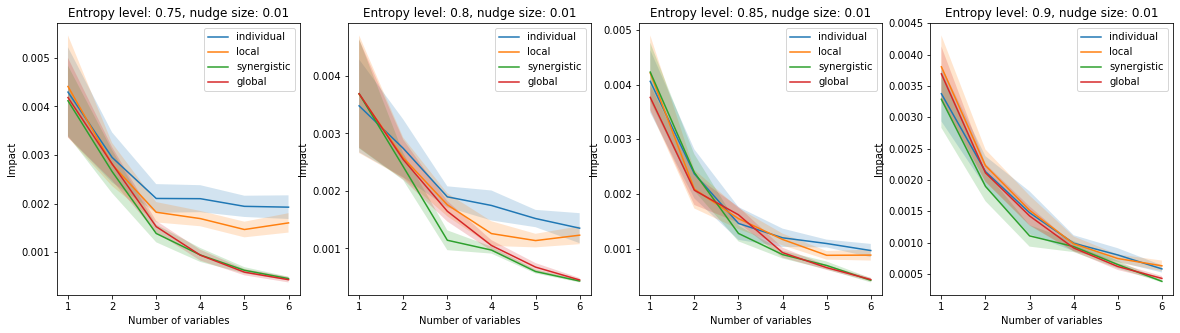

In [23]:
fig, axes = plt.subplots(ncols= 4, nrows=1, figsize=(20,5))
for i, level in enumerate(levels):
    axes[i].plot(n_vars, means_dict[level][:,0], label='individual')
    axes[i].fill_between(n_vars, ci_dict[level][0][:,0],ci_dict[level][1][:,0], alpha=0.2)
    
    axes[i].plot(n_vars, means_dict[level][:,1], label='local')
    axes[i].fill_between(n_vars, ci_dict[level][0][:,1],ci_dict[level][1][:,1],  alpha=0.2)

    axes[i].plot(n_vars, means_dict[level][:,2], label='synergistic')
    axes[i].fill_between(n_vars, ci_dict[level][0][:,2],ci_dict[level][1][:,2], alpha=0.2)


    axes[i].plot(n_vars, means_dict[level][:,3], label='global')
    axes[i].fill_between(n_vars, ci_dict[level][0][:,3],ci_dict[level][1][:,3],alpha=0.2)
    
    axes[i].set_title("Entropy level: {}, nudge size: 0.01".format(level) )
    axes[i].set_xlabel("Number of variables")
    axes[i].set_ylabel("Impact")
    axes[i].legend()
plt.show()
    

# Optimized nudges

In [ ]:
def 